In [11]:
import os
import sys
import time
import tqdm
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [12]:
DATA_PATH = '../dataset'

#File Loading
files = os.listdir(DATA_PATH)
data = [pd.read_csv(os.path.join(DATA_PATH, files[i])) for i in range(len(files)) if files[i].endswith('csv')]
#metadata = pd.read_excel(os.path.join(DATA_PATH, 'MetaData.xlsx'))

In [13]:
#Labeling - Faulted detected sensors / not detected sensors
df = pd.concat([data[i] for i in range(len(data))]).drop_duplicates()
fault_detected = [378, 381, 382, 386, 387, 389, 420, 591, 592, 593, 1113, 2489, 2497]
fault_not_detected = set(df.MeasureId.value_counts().index)- set(fault_detected)

In [14]:
# filter out the indexex where the machine was at a rest
# 구현 요청 사항 : 04.27 14:00 이상치로 판별난 outlier_of_12000에서, 앞뒤 구간 200개 정도씩을 이상치로 추가 포함하고 싶음.
df_598 = df[df.MeasureId==600].reset_index().copy()
preprocessed_df = rolling_processor(df_598, window_size=168, std_window=36, envelope_window=24).reset_index()
preprocessed_df.DateTime=pd.to_datetime(preprocessed_df.DateTime)

outlier_of_12000=preprocessed_df[preprocessed_df.std36<0.04].index


df_961 = df[df.MeasureId==961].reset_index().copy()
preprocessed_df = rolling_processor(df_961, window_size=168, std_window=36, envelope_window=24).reset_index()
preprocessed_df.DateTime=pd.to_datetime(preprocessed_df.DateTime)

outlier_of_10000=preprocessed_df[preprocessed_df.std36<0.05].index

In [15]:
def data_cutter(df, start_point):
    return df.iloc[start_point:,:]
START_POINT=9000

fault_df_dict=df_divider(df, fault_detected)
normal_df_dict=df_divider(df, fault_not_detected)

for i, fault_df in fault_df_dict.items():
    fault_df_dict[i]=normalizer(not_operating_condition_exterminator(fault_df, outlier_of_10000, outlier_of_12000))
    fault_df_dict[i]=rolling_processor(fault_df_dict[i], window_size=168, std_window=168, envelope_window=48)
    fault_df_dict[i]=data_cutter(fault_df_dict[i], START_POINT).reset_index(drop=True)
    fault_df_dict[i]['time_idx']=fault_df_dict[i].index
    
for i, normal_df in normal_df_dict.items():
    normal_df_dict[i]=normalizer(not_operating_condition_exterminator(normal_df, outlier_of_10000, outlier_of_12000))
    normal_df_dict[i]=rolling_processor(normal_df_dict[i], window_size=168, std_window=168, envelope_window=48)
    normal_df_dict[i]=data_cutter(normal_df_dict[i], START_POINT).reset_index(drop=True)
    normal_df_dict[i]['time_idx']=normal_df_dict[i].index

### 전처리 된 데이터 시각화

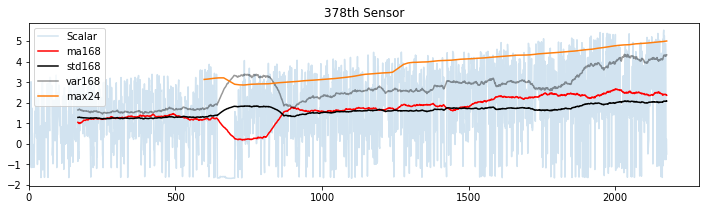

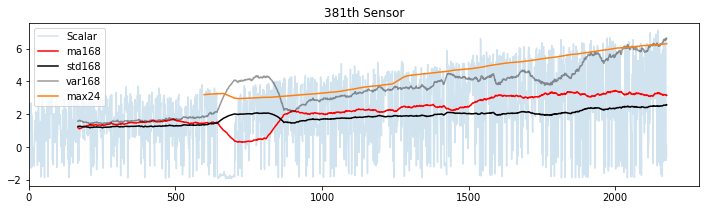

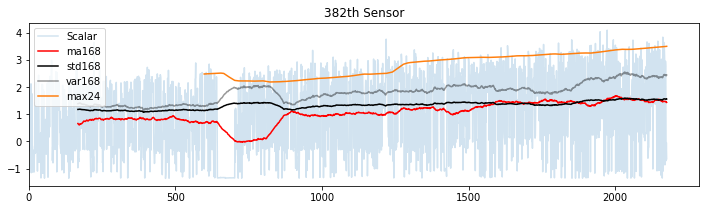

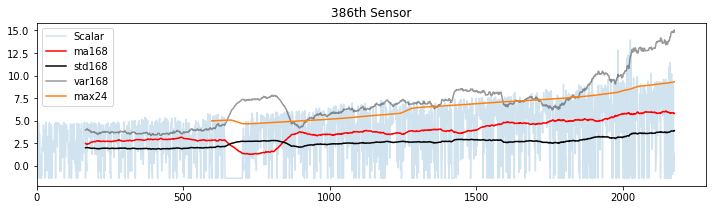

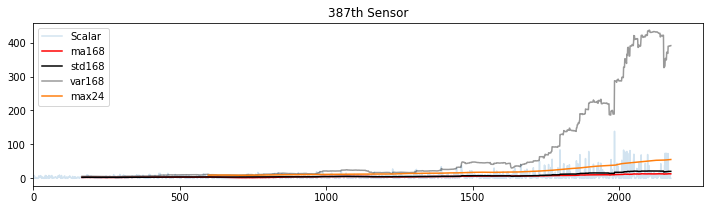

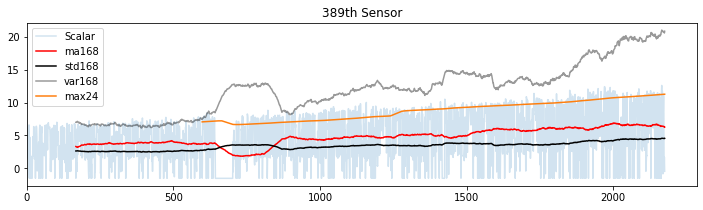

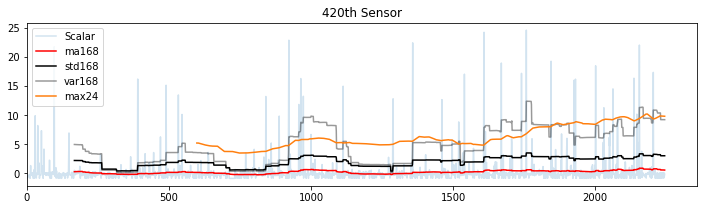

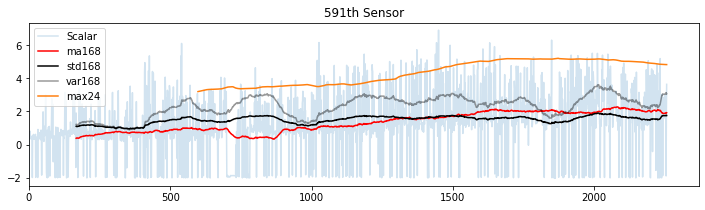

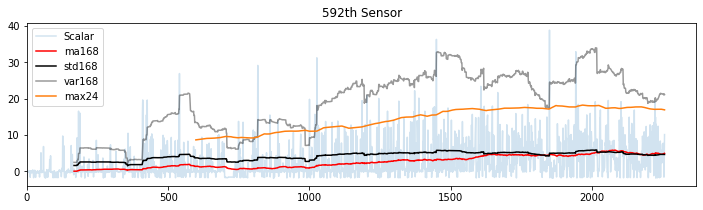

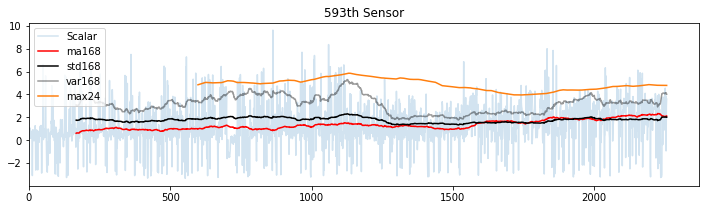

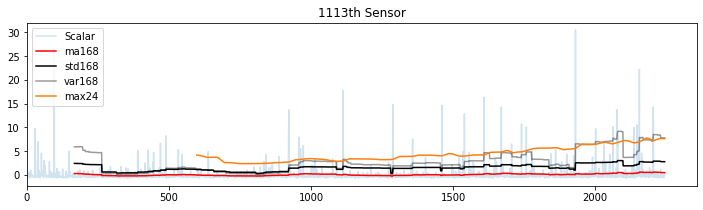

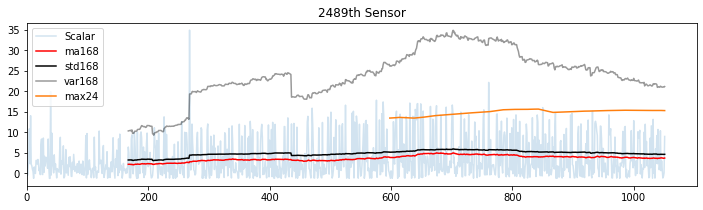

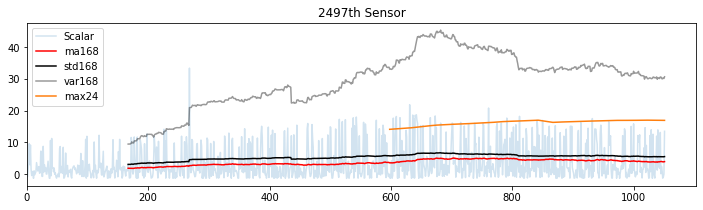

In [9]:
for key, val in fault_df_dict.items():
    visualize_MA_with_std(df=val, measure_id=key, window_size=[168], std_window= 168, envelope_window=24)

# 여기서 부터 분석 하십시오

## 분석 대상
#### fault_df_dict : 고장이 탐지되었음
#### normal_df_dict : 고장이 탐지되지 않았음
위 리스트에서 데이터를 꺼내서 쓰시오

## 전처리 내용
1. 이상치 제거
2. 정규화
3. Moving Average/STD

## 목적 : 양성 데이터에 대해 Recall 1.0인 분류기 만들기